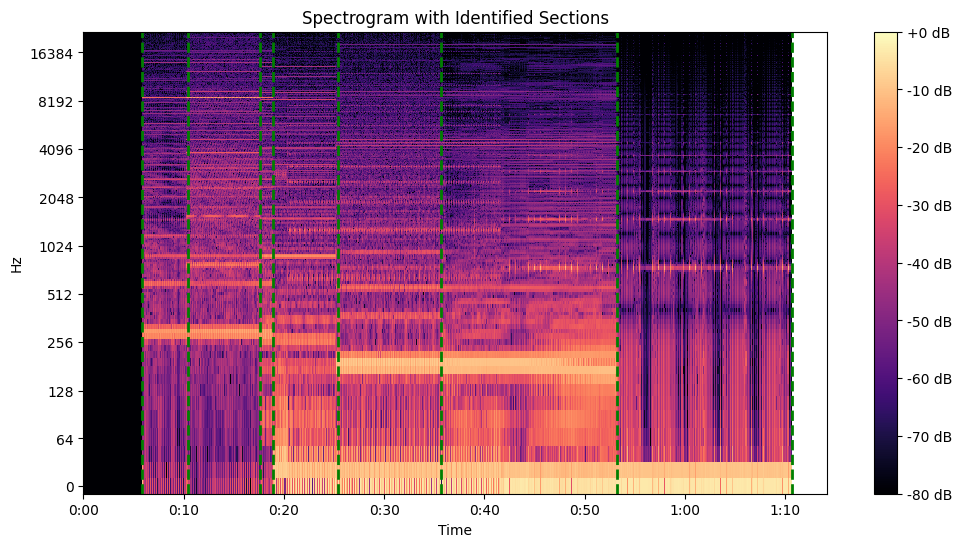

Detected section boundaries (in seconds):
Section 1: 0.00s to 5.86s
Section 2: 5.86s to 10.39s
Section 3: 10.39s to 17.59s
Section 4: 17.59s to 18.92s
Section 5: 18.92s to 25.37s
Section 6: 25.37s to 35.64s
Section 7: 35.64s to 53.23s
Section 8: 53.23s to 70.69s


In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import ruptures as rpt

# load the audio file
filename = 'data/2025_07.wav'
signal, sr = librosa.load(filename, sr=None)

# # STFT parameters
# FFTwindow = 1000
# hop = FFTwindow
# window_fn = 'hann'

# def compute_stft(sig):
#     return np.abs(librosa.stft(sig, n_fft=FFTwindow, hop_length=hop, window=window_fn))

# # create spectrogram
# spectrogram = compute_stft(signal)


# generate stft, default 1024 window, 512 hop
S, phase = librosa.magphase(librosa.stft(signal))

# defining the spectral centroid (proxy for brightness), the weighted average of frequencies in the sound
# sudden changes in the centroid often reflect sudden changes in the sound
centroid = librosa.feature.spectral_centroid(S=S)

# reshape the centroid data for the ruptures library
centroid_reshaped = centroid.T

# find the change points using the pelt (pruned exact linear time) algorithm : change point detection method made to
# find optimal segmentation of a time series. Splits the data sequence into segments where each segment has a consistent
# statistical property e.g. mean/variance
# 
# strives to segment series in every possible way and calculates a cost for those segments based on how uniform the segments are
# and how many segments are made... does this dynamically based on current segement: if bad, pruned immediately as it is segmenting
#
# use of RBF because it is strong at detecting abrupt, non-linear data changes

algo = rpt.Pelt(model="rbf").fit(centroid_reshaped)
result = algo.predict(pen=10) # pen acts like sensitivity parameter, the higher the pen, the less segments will be made

# convert frames to time in seconds, pseudo ifft
times = librosa.frames_to_time(result, sr=sr)

plt.figure(figsize=(12, 6))

librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         sr=sr, x_axis='time', y_axis='log')
plt.title('Spectrogram with Identified Sections')
plt.colorbar(format='%+2.0f dB')

# add vertical lines at the detected change points
for time in times:
    plt.axvline(x=time, color='g', linestyle='--', linewidth=2)

plt.show()

# print the start and end times of the identified sections
print("Detected section boundaries (in seconds):")
section_boundaries = [0] + list(times)
for i in range(len(section_boundaries) - 1):
    start_time = section_boundaries[i]
    end_time = section_boundaries[i+1]
    print(f"Section {i+1}: {start_time:.2f}s to {end_time:.2f}s")

In [29]:
import soundfile as sf
import os

# set dir
output_directory = 'audio_segments'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# define boundaires
segment_boundaries = [0] + list(times) + [librosa.get_duration(y=y, sr=sr)]

# extract and save each segment
print("Extracting and saving segments...")
for i in range(len(segment_boundaries) - 1):
    start_time = segment_boundaries[i]
    end_time = segment_boundaries[i+1]
    
    # Convert times to sample indices
    start_sample = int(librosa.time_to_samples(start_time, sr=sr))
    end_sample = int(librosa.time_to_samples(end_time, sr=sr))
    
    # Extract the segment from the original audio
    segment = y[start_sample:end_sample]
    
    # Create a filename for the segment
    filename = f"data/{output_directory}/segment_{i+1:02d}.wav"
    
    # save the segment as a WAV file
    sf.write(filename, segment, sr)
    
    print(f"Saved {filename}: {start_time:.2f}s to {end_time:.2f}s")

print("All segments saved successfully!")

Extracting and saving segments...
Saved data/audio_segments/segment_01.wav: 0.00s to 5.86s
Saved data/audio_segments/segment_02.wav: 5.86s to 10.39s
Saved data/audio_segments/segment_03.wav: 10.39s to 17.59s
Saved data/audio_segments/segment_04.wav: 17.59s to 18.92s
Saved data/audio_segments/segment_05.wav: 18.92s to 25.37s
Saved data/audio_segments/segment_06.wav: 25.37s to 35.64s
Saved data/audio_segments/segment_07.wav: 35.64s to 53.23s
Saved data/audio_segments/segment_08.wav: 53.23s to 70.69s
Saved data/audio_segments/segment_09.wav: 70.69s to 70.68s
All segments saved successfully!
